In [1]:
import numpy as np
import matplotlib.pyplot as plt

import serial
import time

from serial_com import Communication
from path_maker import PathMaker

import xml.etree.ElementTree as ET

In [53]:
tree = ET.parse("test_image_zajcek.svg")
# tree = ET.parse("test_path.svg")

root = tree.getroot()

ns = {"svg" : "http://www.w3.org/2000/svg"}

In [24]:
ret

In [60]:
ret = root.findall(".//svg:path", ns)

In [61]:
ret

[<Element '{http://www.w3.org/2000/svg}path' at 0x000001F4931AA700>]

In [64]:
temp = ret[0].attrib["d"]

In [65]:
import re

In [66]:
tokens = re.findall(r'[a-zA-Z]|-?\d+(?:\.\d+)?', temp)

In [67]:
tokens

['m',
 '26.35976',
 '-218.42781',
 'v',
 '35.36252',
 'l',
 '-9.34106',
 '38.69862',
 '-9.3410504',
 '32.69365',
 '-2.668879',
 '30.02481',
 '2.00168',
 '22.68535',
 '9.3410194',
 '18.682106',
 '-20.6837054',
 '-10.008276',
 '-26.0214986',
 '-1.33441',
 '-29.357549',
 '6.004947',
 '-30.02479',
 '14.011559',
 '-13.344347',
 '19.349301',
 '-14.01156',
 '22.0181881',
 'V',
 '41.119784',
 'l',
 '2.00164',
 '-35.3625369',
 '-6.67216',
 '-15.346001',
 '-8.67383',
 '-9.3410501',
 '-15.346',
 '18.01488012',
 '-6.67218',
 '30.02476988',
 '4.67053',
 '20.683755',
 '10.67547',
 '12.009924',
 '11.3427',
 '6.672181',
 '10.67547',
 '4.0033',
 '-4.67051',
 '-10.675481',
 '10.67548',
 '25.354247',
 '13.600136',
 '17.793088',
 '18.927181',
 '9.85266',
 '26.633264',
 '5.18214',
 '22.273967',
 '3.02484',
 '27.54554509',
 '2.04639',
 '-4.97101809',
 '-16.55886',
 '-19.277234',
 '-20.402298',
 '-18.944344',
 '0.668029',
 '21.483771',
 '-0.972818',
 '16.1474066',
 '-11.308637',
 '7.33941',
 '-15.345998',
 '

In [101]:
import os

def makeitem(size: int = 5) -> str:
    return os.urandom(size).hex()

In [107]:
os.urandom(5)

b"\xe9'c`\xd7"

In [106]:
makeitem()

'b54c326be8'

In [93]:
def get_path_from_svg(filename: str) -> list[str] | None:
    tree = ET.parse(filename)

    root = tree.getroot()

    ns = {"svg" : "http://www.w3.org/2000/svg"}

    ret = root.findall(".//svg:path", ns)

    if ret is None:
        print("Failed to find any paths")
        return None
    
    ret_list = []

    for path in ret:
        d_attr = path.attrib["d"]
        ret_list.append(d_attr)    

    return ret_list


def get_pts_from_svg(filename: str) -> list[np.ndarray]:
    path_list = get_path_from_svg(filename)

    if path_list is None:
        return None
    
    def next_float():
        nonlocal idx
        val = float(tokens[idx])
        idx += 1
        return val
    
    ret_vals = []

    for path in path_list:

        # https://www.rexegg.com/regex-quickstart.php
        tokens = re.findall(r'[a-zA-Z]|-?\d+(?:\.\d+)?', path)
        idx = 0
        positions = []
        cur_pos = [0, 0]
        cmd = None

        while idx < len(tokens):
            val = tokens[idx]

            if re.match(r"[a-zA-Z]", val):
                cmd = val
                idx += 1

            match cmd:
                case "m":
                    cur_pos[0] += next_float()
                    cur_pos[1] += next_float()
                    # the following tokens are treated as relative lineto values
                    cmd = "l"
                    positions.append(cur_pos.copy())
                case "M":
                    cur_pos[0] = next_float()
                    cur_pos[1] = next_float()
                    # the following tokens are treated as absolute lineto values
                    cmd = "L"
                    positions.append(cur_pos.copy())
                case "l":
                    cur_pos[0] += next_float()
                    cur_pos[1] += next_float()
                    positions.append(cur_pos.copy())
                case "L":
                    cur_pos[0] = next_float()
                    cur_pos[1] = next_float()
                    positions.append(cur_pos.copy())
                case "v":
                    cur_pos[1] += next_float()
                    positions.append(cur_pos.copy())
                case "V":
                    cur_pos[1] = next_float()
                    positions.append(cur_pos.copy())
                case "h":
                    cur_pos[0] += next_float()
                    positions.append(cur_pos.copy())
                case "H":
                    cur_pos[0] = next_float()
                    positions.append(cur_pos.copy())
                case "z":
                    cur_pos = positions[0]
                    positions.append(cur_pos.copy())
                case "Z":
                    cur_pos = positions[0]
                    positions.append(cur_pos.copy())
                case _:
                    print(f"Received unsupported command {cmd}")
                    break
    
        if len(positions) != 0:
            ret_vals.append(np.array(positions))

    
    return ret_vals

In [94]:
ret = get_path_from_svg("test_img.svg")

In [88]:
ret

['m 83.515744,217.05001 20.361846,6.59484 24.93932,-3.31084 15.18043,-18.01336 2.59989,-22.89069 -7.58668,-15.09801 -13.73276,-3.51207 -13.13807,3.37627 -29.298063,2.53446 29.622583,-3.23547 3.51205,-101.392736 -9.43185,5.33131 -16.44979,1.32478 16.25437,-3.17612 12.00415,-5.00796 3.78875,-3.80995 2.12014,-18.6367 -8.63653,-18.377051 -20.658007,-5.02089 -1.665859,21.289341 -2.428984,-0.78948 1.680934,-20.661101 -17.330714,0.51079 -12.347488,11.77782 -4.081699,18.144021 1.309948,12.21681 13.86309,8.26373 16.127899,3.27674 -10.1686,-1.0346 -13.154926,-4.94945 -3.189545,96.755496 19.260078,7.20067 -32.163088,-12.86655 -19.686985,3.63562 -12.340412,21.93028 2.91532,24.48193 16.092557,15.46173 19.13854,2.19502 22.732961,-4.23941']

In [86]:
ret[0]

array([[ 83.515744, 217.05001 ]])

In [68]:
test = []

pos = [0,0]

In [71]:
pos[0] += 5
pos[1] += 1

test.append(pos)

In [72]:
pos[0] = 10
pos[1] = 15

test.append(pos)

In [73]:
test

[[10, 15], [10, 15]]

In [2]:
import re


def parse_svg_path(d):
    tokens = re.findall(r'[a-zA-Z]|-?\d+(?:\.\d+)?', d)
    idx = 0
    points = []
    current_pos = [0.0, 0.0]
    cmd = None

    def next_float():
        nonlocal idx
        val = float(tokens[idx])
        idx += 1
        return val

    while idx < len(tokens):
        token = tokens[idx]

        # If token is a letter, update the command
        if re.match(r'[a-zA-Z]', token):
            cmd = token
            idx += 1

        if cmd == 'm':
            # Relative moveto
            dx = next_float()
            dy = next_float()
            current_pos[0] += dx
            current_pos[1] += dy
            points.append(current_pos.copy())
            cmd = 'l'  # Subsequent pairs are treated as relative lines
        elif cmd == 'M':
            # Absolute moveto
            x = next_float()
            y = next_float()
            current_pos = [x, y]
            points.append(current_pos.copy())
            cmd = 'L'  # Subsequent pairs are treated as absolute lines
        elif cmd == 'l':
            # Relative lineto
            dx = next_float()
            dy = next_float()
            current_pos[0] += dx
            current_pos[1] += dy
            points.append(current_pos.copy())
        elif cmd == 'L':
            # Absolute lineto
            x = next_float()
            y = next_float()
            current_pos = [x, y]
            points.append(current_pos.copy())
        elif cmd == 'v':
            # Relative vertical lineto
            dy = next_float()
            current_pos[1] += dy
            points.append(current_pos.copy())
        elif cmd == 'V':
            # Absolute vertical lineto
            y = next_float()
            current_pos[1] = y
            points.append(current_pos.copy())
        elif cmd == 'h':
            # Relative horizontal lineto
            dx = next_float()
            current_pos[0] += dx
            points.append(current_pos.copy())
        elif cmd == 'H':
            # Absolute horizontal lineto
            x = next_float()
            current_pos[0] = x
            points.append(current_pos.copy())
        else:
            continue
            # raise ValueError(f"Unsupported command: {cmd}")

    return points

In [3]:
tree = ET.parse("test_img_sovica.svg")
# tree = ET.parse("test_img_zajcek.svg")
root = tree.getroot()

ns = {"svg" : "http://www.w3.org/2000/svg"}

path_element = root.find(".//svg:path", ns)

if path_element is not None:
    d_attr = path_element.attrib["d"]
pts = parse_svg_path(d_attr)
pts = np.array(pts)

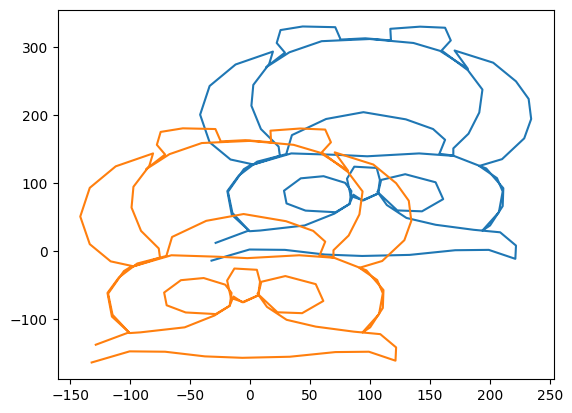

In [4]:
plt.plot(pts[:,0], pts[:,1]+0)

new_pts = pts + [-100, -150]
plt.plot(new_pts[:,0], new_pts[:,1]+0)


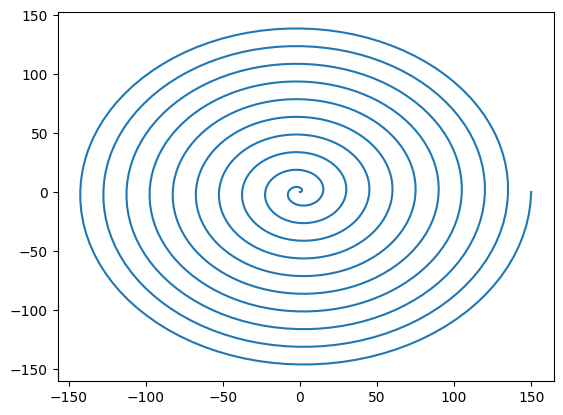

In [2]:
num = 1000
RADIUS_STEPS_MM = 81.82 # steps per mm for the radial position
ANGLE_STEPS_RAD = 4169.86 # steps per radian of rotation

steps_phi = np.zeros(num, dtype=np.int32)

r = np.linspace(0, 150, num)
phi = np.linspace(0, 20*np.pi, num)

steps_r = (r*RADIUS_STEPS_MM).astype(np.int32)
steps_phi[0] += (phi[0]*ANGLE_STEPS_RAD).astype(np.int32)
steps_phi[1:] += (np.diff(np.unwrap(phi))*ANGLE_STEPS_RAD).astype(np.int32)

x = r*np.cos(phi)
y = r*np.sin(phi)

plt.plot(x, y)


In [ ]:
def spiral_path_about_center(r0: float = 0, r1: float = 250, num: int = 10, interpolate: bool = False):
    """
    To create a spiral movement we only need to pass 2 points due
    to the nature of our system. To feed the values to the Sand table
    you must first pass the points to the PathMaker class.

    :param r0: what radius to start at
    :param r1: what radius to end at
    :param num: how many spiral revolutions
    :param interpolate: if True returns an array of points that can be plotted
    """

    theta



In [3]:
a = 201
input_path = np.array([
    [a/2, a/2],
    [-a/2, a/2],
    [-a/2, -a/2],
    [a/2, -a/2],
    [a/2,a/2]
])

a = 100
input_path = np.array([
    [0, 2*a],
    [a, a],
    [0, 0],
    [-a, a],
    [0,2*a]
])

In [10]:
a = 100
input_path = np.array([
    [0, a],
    [-a, -a],
    [a, -a],
    [0, a]
])

In [5]:
# path = PathMaker(input_path, eps=5, rot_angle=15)
path = PathMaker(new_pts, eps=5, rot_angle=0)

In [6]:
com = Communication("COM9", path)

In [9]:
msg = com.HEADER + b"e"
# com.toggle()
com.serial.write(msg)

3

In [10]:
com.serial.in_waiting

3

In [19]:
rec = com.serial.read(3)

com.update_pos(next(path))


In [11]:
while True:
    rec = com.serial.read(3)

    # print(rec)

    # com.update_pos((r0, phi0))
    com.update_pos(next(path))

    time.sleep(0.1)

# com.serial.in_waiting

SerialException: WriteFile failed (PermissionError(13, 'The device does not recognize the command.', None, 22))

In [ ]:

for r0, phi0 in zip(steps_r, steps_phi):
    rec = com.serial.read(3)

    # print(rec)

    com.update_pos((r0, phi0))
    # com.update_pos(next(path))

    time.sleep(0.1)

# com.serial.in_waiting

In [94]:
# while


com.update_pos(next(path))

In [116]:
com.update_pos(next(path))

In [78]:
com.serial.in_waiting

133

In [12]:
com.toggle()

In [ ]:
com.begin()

Starting


rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated
rec
	updated

In [22]:
com.serial.flushInput()

In [16]:
pt = next(path)
com.update_pos(pt)

In [23]:
isinstance(pt[0], (int, np.int32))

True

In [ ]:
# com.toggle()

while True:
    # if com.serial.in_waiting > 0:
    rec = com.serial.read()

    # if rec == com.FINISH_MOVE:
    pos = next(com.path_maker)
    com.update_pos(pos)

    com.serial.flushInput()

    time.sleep(0.1)

In [23]:
rec == com.FINISH_MOVE

True

In [25]:
pos
com.update_pos(pos)

In [22]:
rec

b'f'

In [13]:
com.toggle()

In [26]:
com.serial.in_waiting

59

In [18]:
pt = next(path)
pt

array([10594,   152], dtype=int32)

In [11]:
com.serial.inWaiting()

0

In [ ]:
rec = com.serial.read()

In [9]:
com.toggle()

In [5]:
com.begin()

In [6]:
size = 200
out = np.zeros((size,2))

for i in range(size):
    ret = next(path)
    out[i] += ret

In [8]:
x = out[:,0]*np.cos(out[:,1])
y = out[:,0]*np.sin(out[:,1])

In [11]:
%matplotlib qt
plt.plot(x, y, '.')

In [38]:
pts = path.positions

In [39]:
pts.shape

(97, 2)

In [6]:
com = Communication("COM9")

In [23]:
com.serial.in_waiting

511

In [27]:
com.serial.flushInput()

com.serial.in_waiting

0

In [24]:
com.serial.flushInput()
msg = com.update_speed(1000)

com.serial.write(msg)

5

In [42]:

for i, pt in enumerate(pts):

    rec = com.serial.read()
    com.serial.flushInput()

    msg = com.update_pos([int(pt[0]+5000), int(pt[1])])
    print(msg)
    com.serial.write(msg)

    time.sleep(0.1)
    # com.wait_for_response()
# time.sleep(1)

# rec = com.serial.readline()
# print(rec)

b'abc\x00\x003}\x00\x00\x00\x00'
b'abc\x00\x001\x82\x00\x00\x00\x8a'
b'abc\x00\x00/\x91\x00\x00\x00\x9e'
b'abc\x00\x00-\xab\x00\x00\x00\xb5'
b'abc\x00\x00+\xd5\x00\x00\x00\xd1'
b'abc\x00\x00*\x10\x00\x00\x00\xf3'
b'abc\x00\x00(b\x00\x00\x01\x1b'
b'abc\x00\x00&\xd2\x00\x00\x01K'
b'abc\x00\x00%e\x00\x00\x01\x82'
b"abc\x00\x00$'\x00\x00\x01\xc1"
b'abc\x00\x00#!\x00\x00\x02\x02'
b'abc\x00\x00"a\x00\x00\x02@'
b'abc\x00\x00!\xef\x00\x00\x02p'
b'abc\x00\x00!\xd4\x00\x00\x02\x88'
b'abc\x00\x00"\x12\x00\x00\x02\x82'
b'abc\x00\x00"\xa5\x00\x00\x02_'
b'abc\x00\x00#\x82\x00\x00\x02('
b'abc\x00\x00$\xa0\x00\x00\x01\xe8'
b'abc\x00\x00%\xf2\x00\x00\x01\xa7'
b"abc\x00\x00'n\x00\x00\x01k"
b'abc\x00\x00)\x0b\x00\x00\x017'
b'abc\x00\x00*\xc3\x00\x00\x01\n'
b'abc\x00\x00,\x8f\x00\x00\x00\xe5'
b'abc\x00\x00.l\x00\x00\x00\xc5'
b'abc\x00\x000W\x00\x00\x00\xab'
b'abc\x00\x002L\x00\x00\x00\x96'
b'abc\x00\x004K\x00\x00\x00\x84'
b'abc\x00\x006Q\x00\x00\x00t'
b'abc\x00\x008]\x00\x00\x00g'
b'abc\x00\x00:n\x00\x00\

In [40]:
com.serial.inWaiting()

342

In [10]:
rec = com.serial.read(1)
rec

b'f'

In [8]:
ord("f")

102

In [12]:
rec = com.serial.read()
rec

b'7'

In [12]:
ord("c")

99

In [ ]:
979899

In [7]:
rec

b'97989958430\r\n'

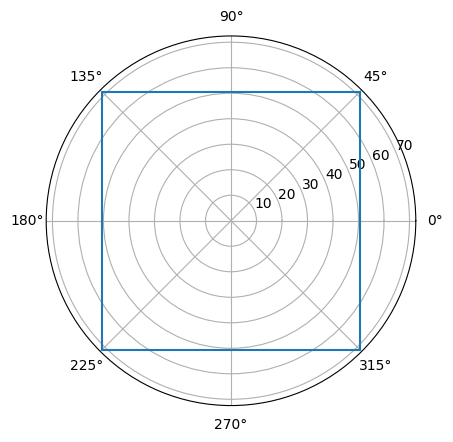

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(path.pts_polar[:,1], path.pts_polar[:,0])
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

plt.show()


In [8]:
np.cumsum(path.positions[:,1])

array([    0,   277,   591,   945,  1340,  1777,  2251,  2753,  3271,
        3789,  4291,  4765,  5202,  5597,  5951,  6265,  6542,  6819,
        7133,  7487,  7882,  8319,  8793,  9295,  9813, 10331, 10833,
       11307, 11744, 12139, 12493, 12807, 13084, 13361, 13675, 14029,
       14424, 14861, 15335, 15837, 16355, 16873, 17375, 17849, 18286,
       18681, 19035, 19349, 19626, 19903, 20217, 20571, 20966, 21403,
       21877, 22379, 22897, 23415, 23917, 24391, 24828, 25223, 25577,
       25891, 26168])

In [46]:
from path_maker import _calc_trajectory, _calc_triag

In [47]:
pt0 = [-a/2, a/2]
pt1 = [-a/2, -a/2]

x0, y0 = pt0
x1, y1 = pt1
r0, phi0 = np.sqrt(x0**2+y0**2), np.atan2(y0, x0)
r1, phi1 = np.sqrt(x1**2+y1**2), np.atan2(y1, x1)

r01 = (r0+r1)/2
phi01 = (phi0+phi1)/2
x01p, y01p = r01*np.cos(phi01), r01*np.sin(phi01)

A = _calc_triag((x0, y0), (x01p, y01p), (x1, y1))

x01, y01 = (x0+x1)/2, (y0+y1)/2

In [56]:
x01p, y01p

(np.float64(71.4177848998413), np.float64(0.0))

In [49]:
x01, y01

(-50.5, 0.0)

In [ ]:
def _calc_trajectory2(pt0, pt1, eps: float = 5) -> list[list[float]]:
    """
    Calculate the minimal required steps to make a straight line on the sand
    table based on the desired accuracy.

    :param pt0: tuple of (x0, y0)
    :param pt1: tuple of (x1, y1)
    :param eps: desired accurary. Calculated as triangle area between three
        points, where the three points are the start and end of the line and
        the middle arc point.

    :return: list of positions with shape [n, 2]
    """
    x0, y0 = pt0
    x1, y1 = pt1
    r0, phi0 = np.sqrt(x0**2+y0**2), np.atan2(y0, x0)
    r1, phi1 = np.sqrt(x1**2+y1**2), np.atan2(y1, x1)

    # dosezemo, da so vsi koti vedno pozitivni -> tako ne more priti do tezav pri iskanju srednjega kota    
    if phi0 < 0:
        phi0 += 2*np.pi
    if phi1 < 0:
        phi1 += 2*np.pi


    r01 = (r0+r1)/2
    phi01 = (phi0+phi1)/2
    x01p, y01p = r01*np.cos(phi01), r01*np.sin(phi01)

    A = _calc_triag((x0, y0), (x01p, y01p), (x1, y1))

    x01, y01 = (x0+x1)/2, (y0+y1)/2
    vals = np.array([x0, y0, x1, y1, A, r01, phi01, x01p, y01p])
    for val in vals:
        print(f"{val:#.3f}\t", end="")
    print("\n")
    
    if A > eps:
        new_seg0 = _calc_trajectory2(pt0, (x01, y01), eps)
        new_seg1 = _calc_trajectory2((x01, y01), pt1, eps)

        ret_list = [*new_seg0, *new_seg1[1:]]

    else:
        ret_list = [pt0, (x01, y01), pt1]

    return ret_list

In [72]:
x0, y0 = -50.500, 0.000	
x1, y1 = -50.500, -50.500

In [78]:
r0, phi0 = np.sqrt(x0**2+y0**2), np.atan2(y0, x0)
r1, phi1 = np.sqrt(x1**2+y1**2), np.atan2(y1, x1)

if phi0 < 0:
    phi0 += 2*np.pi
if phi1 < 0:
    phi1 += 2*np.pi

r01 = (r0+r1)/2
phi01 = (phi0+phi1)/2
x01p, y01p = r01*np.cos(phi01), r01*np.sin(phi01)

In [ ]:
vals = np.array([x0, y0, x1, y1, A, r01, phi01, x01p, y01p])
-50.500	0.000	-50.500	-50.500	2697.171	60.959	0.393	56.319	23.328

In [71]:
_calc_triag([-50.5, 0], [-50.5, -50.5], [-56.3, -23.3])

146.44999999999993

In [83]:
ret = _calc_trajectory2([-a/2, a/2], [-a/2, -a/2])

-50.500	50.500	-50.500	-50.500	1056.348	71.418	3.142	-71.418	0.000	

-50.500	50.500	-50.500	0.000	146.921	60.959	2.749	-56.319	23.328	

-50.500	50.500	-50.500	25.250	17.299	63.939	2.517	-51.870	37.386	

-50.500	50.500	-50.500	37.875	2.023	67.271	2.427	-50.820	44.076	

-50.500	37.875	-50.500	25.250	2.290	59.793	2.588	-50.863	31.435	

-50.500	25.250	-50.500	0.000	19.565	53.480	2.910	-52.050	12.287	

-50.500	25.250	-50.500	12.625	2.445	54.257	2.787	-50.887	18.824	

-50.500	12.625	-50.500	0.000	2.480	51.277	3.019	-50.893	6.265	

-50.500	0.000	-50.500	-50.500	146.921	60.959	3.534	-56.319	-23.328	

-50.500	0.000	-50.500	-25.250	19.565	53.480	3.373	-52.050	-12.287	

-50.500	0.000	-50.500	-12.625	2.480	51.277	3.264	-50.893	-6.265	

-50.500	-12.625	-50.500	-25.250	2.445	54.257	3.496	-50.887	-18.824	

-50.500	-25.250	-50.500	-50.500	17.299	63.939	3.766	-51.870	-37.386	

-50.500	-25.250	-50.500	-37.875	2.290	59.793	3.695	-50.863	-31.435	

-50.500	-37.875	-50.500	-50.500	2.023	67.271	3.856	-50.820

In [84]:
ret

[[-50.5, 50.5],
 (-50.5, 44.1875),
 (-50.5, 37.875),
 (-50.5, 31.5625),
 (-50.5, 25.25),
 (-50.5, 18.9375),
 (-50.5, 12.625),
 (-50.5, 6.3125),
 (-50.5, 0.0),
 (-50.5, -6.3125),
 (-50.5, -12.625),
 (-50.5, -18.9375),
 (-50.5, -25.25),
 (-50.5, -31.5625),
 (-50.5, -37.875),
 (-50.5, -44.1875),
 [-50.5, -50.5]]

In [8]:
path.pts_polar[:,1]

array([ 7.85398163e-01,  8.51966327e-01,  9.27295218e-01,  1.01219701e+00,
        1.10714872e+00,  1.21202566e+00,  1.32581766e+00,  1.44644133e+00,
        1.57079633e+00,  1.69515132e+00,  1.81577499e+00,  1.92956700e+00,
        2.03444394e+00,  2.12939564e+00,  2.21429744e+00,  2.28962633e+00,
        2.35619449e+00,  2.42276265e+00,  2.49809154e+00,  2.58299334e+00,
        2.67794504e+00,  2.78282198e+00,  2.89661399e+00,  3.01723766e+00,
        3.14159265e+00, -3.01723766e+00, -2.89661399e+00, -2.78282198e+00,
       -2.67794504e+00, -2.58299334e+00, -2.49809154e+00, -2.42276265e+00,
       -2.35619449e+00, -2.28962633e+00, -2.21429744e+00, -2.12939564e+00,
       -2.03444394e+00, -1.92956700e+00, -1.81577499e+00, -1.69515132e+00,
       -1.57079633e+00, -1.44644133e+00, -1.32581766e+00, -1.21202566e+00,
       -1.10714872e+00, -1.01219701e+00, -9.27295218e-01, -8.51966327e-01,
       -7.85398163e-01, -7.18830000e-01, -6.43501109e-01, -5.58599315e-01,
       -4.63647609e-01, -

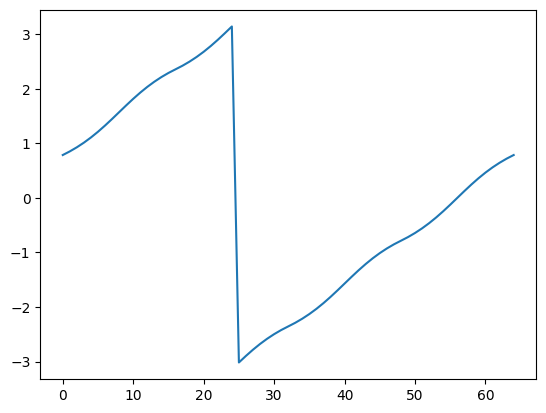

In [5]:
plt.plot(path.pts_polar[:,1])

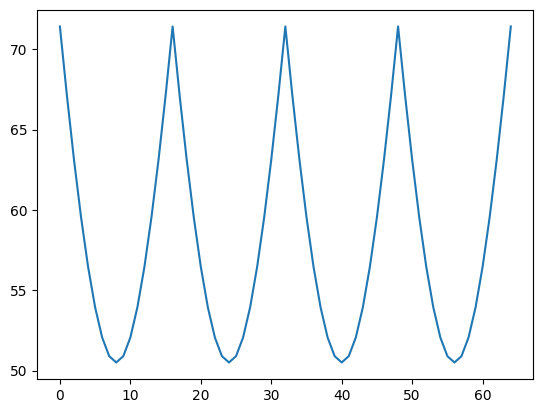

In [6]:
plt.plot(path.pts_polar[:,0])

In [11]:
path.pts_polar[:,1]

array([ 0.78539816,  0.85196633,  0.92729522,  1.01219701,  1.10714872,
        1.21202566,  1.32581766,  1.44644133,  1.57079633,  1.69515132,
        1.81577499,  1.929567  ,  2.03444394,  2.12939564,  2.21429744,
        2.28962633,  2.35619449,  2.42276265,  2.49809154,  2.58299334,
        2.67794504,  2.78282198,  2.89661399,  3.01723766,  3.14159265,
       -3.01723766, -2.89661399, -2.78282198, -2.67794504, -2.58299334,
       -2.49809154, -2.42276265, -2.35619449, -2.28962633, -2.21429744,
       -2.12939564, -2.03444394, -1.929567  , -1.81577499, -1.69515132,
       -1.57079633, -1.44644133, -1.32581766, -1.21202566, -1.10714872,
       -1.01219701, -0.92729522, -0.85196633, -0.78539816, -0.71883   ,
       -0.64350111, -0.55859932, -0.46364761, -0.35877067, -0.24497866,
       -0.12435499,  0.        ,  0.12435499,  0.24497866,  0.35877067,
        0.46364761,  0.55859932,  0.64350111,  0.71883   ,  0.78539816])

In [12]:
26200/(2*np.pi)

4169.859509007658

In [7]:
path.positions.shape

(65, 2)

In [8]:
np.min(path.positions[:,1])

np.int32(-80680)

In [13]:
ser = serial.Serial("COM9", 115200)

SerialException: could not open port 'COM9': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

In [142]:
ser.write(b"22500, 26200, 11")

time.sleep(0.5)

rec = ser.read_all()
print(rec)

b'Received\r\nMoved to pos\r\n'


In [143]:
ser.close()

In [144]:
temp = b"0x6162"

In [157]:
chr()

TypeError: chr() takes exactly one argument (0 given)

In [163]:
hex(ord("f"))

'0x66'

In [145]:
temp.decode("utf-8")

'0x6162'

In [ ]:
b"500, 500, 11"

b'11, 500, 500'

In [ ]:
"ab"

In [131]:

rec = ser.read_all()
print(rec)

b'False input\r\n'


In [66]:
a = 50
path = np.array([
    [0, a],
    [a/2,0],
    [-a,1],
    [0,a]
])

In [67]:
x = path[:,0]
y = path[:,1]

r = np.sqrt(x**2+y**2)
phi = np.atan2(y,x)

path_pol = np.vstack((r, phi)).T

In [123]:
np.vstack((path, path))

array([[  0.,  50.],
       [ 25.,   0.],
       [-50.,   1.],
       [  0.,  50.],
       [  0.,  50.],
       [ 25.,   0.],
       [-50.,   1.],
       [  0.,  50.]])

In [5]:
test = np.array([0,5,6,6,3,6,6,2,6,7])

In [19]:
np.all(test < 7)

np.False_

In [26]:
True is np.all(test < 10)

False

In [68]:
x2 = r*np.cos(phi)
y2 = r*np.sin(phi)

In [69]:
def interpolate_path(pt0: tuple, pt1:tuple, num=100):
    x0, y0 = pt0
    x1, y1 = pt1

    xi = np.linspace(x0, x1, num)
    yi = np.linspace(y0, y1, num)

    return xi, yi

In [70]:
px, py = interpolate_path(path_pol[0], path_pol[1])

In [58]:
x2 = px*np.cos(py)
y2 = px*np.sin(py)

In [59]:
path_pol

array([[50.        ,  1.57079633],
       [25.        ,  0.        ],
       [50.009999  , -3.12159532],
       [50.        ,  1.57079633]])

In [72]:
np.unwrap(path_pol[:,1], discont=np.pi/2)

array([1.57079633, 0.        , 3.12159532, 1.57079633])

In [64]:
path_pol[:, 1] = np.unwrap(path_pol[:,1], discont=np.pi/2)

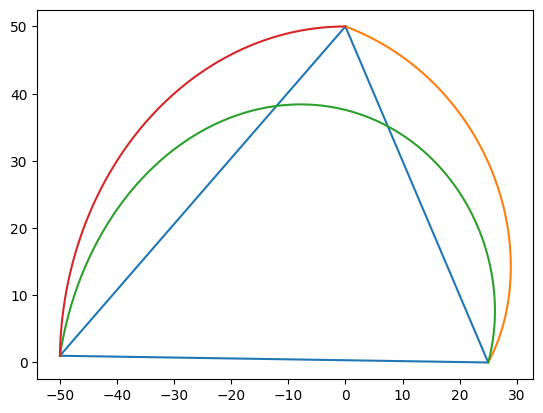

In [71]:
plt.plot(x, y)

for i in range(path_pol.shape[0]-1):
    ri, phii = interpolate_path(path_pol[i], path_pol[i+1])

    xi = ri*np.cos(phii)
    yi = ri*np.sin(phii)

    plt.plot(xi, yi)

In [107]:
def calc_triag(pt0: tuple, pt1: tuple, pt2: tuple):
    """
    Triangle area based on points.
    https://en.wikipedia.org/wiki/Area_of_a_triangle
    """
    
    xa, ya = pt0
    xb, yb = pt1
    xc, yc = pt2

    return 0.5*abs((xa-xc)*(yb-ya) - (xa-xb)*(yc-ya))


def calc_trajectory(pt0, pt1, eps: float = 10):
    x0, y0 = pt0
    x1, y1 = pt1
    r0, phi0 = np.sqrt(x0**2+y0**2), np.atan2(y0, x0)
    r1, phi1 = np.sqrt(x1**2+y1**2), np.atan2(y1, x1)

    r01 = (r0+r1)/2
    phi01 = (phi0+phi1)/2
    x01p, y01p = r01*np.cos(phi01), r01*np.sin(phi01)

    A = calc_triag((x0, y0), (x01p, y01p), (x1, y1))

    x01, y01 = (x0+x1)/2, (y0+y1)/2

    if A > eps:
        new_seg0 = calc_trajectory(pt0, (x01, y01), eps)
        new_seg1 = calc_trajectory((x01, y01), pt1, eps)

        ret_list = [*new_seg0, *new_seg1[1:]]

    else:
        ret_list = [pt0, (x01, y01), pt1]

    return ret_list
    

In [81]:
path[0], path[1]

(array([ 0., 50.]), array([25.,  0.]))

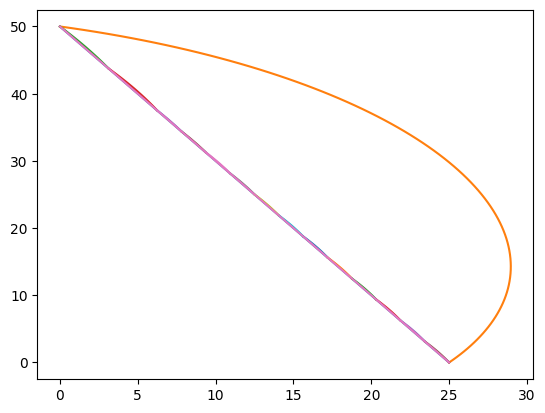

In [117]:
plt.plot(path[:2, 0], path[:2, 1])

ri, phii = interpolate_path(path_pol[0], path_pol[1])

xi = ri*np.cos(phii)
yi = ri*np.sin(phii)

plt.plot(xi, yi)

ret = calc_trajectory(path[0], path[1], 5)
ret = np.array(ret)

for i in range(ret.shape[0]-1):
    r0, phi0 = np.sqrt(ret[i][0]**2 + ret[i][1]**2), np.atan2(ret[i][1], ret[i][0])
    r1, phi1 = np.sqrt(ret[i+1][0]**2 + ret[i+1][1]**2), np.atan2(ret[i+1][1], ret[i+1][0])
    ri, phii = interpolate_path((r0, phi0), (r1, phi1))

    xi = ri*np.cos(phii)
    yi = ri*np.sin(phii)

    plt.plot(xi, yi)

plt.plot()
plt.plot(ret[:,0], ret[:, 1])


In [101]:
path[:2]

array([[ 0., 50.],
       [25.,  0.]])

In [104]:
ret = calc_trajectory(path[0], path[1])

[array([ 0., 50.]), (np.float64(3.125), np.float64(43.75)), (np.float64(6.25), np.float64(37.5))]
[(np.float64(6.25), np.float64(37.5)), (np.float64(9.375), np.float64(31.25)), (np.float64(12.5), np.float64(25.0))]
[array([ 0., 50.]), (np.float64(3.125), np.float64(43.75)), (np.float64(6.25), np.float64(37.5)), (np.float64(9.375), np.float64(31.25)), (np.float64(12.5), np.float64(25.0))]
[(np.float64(12.5), np.float64(25.0)), (np.float64(15.625), np.float64(18.75)), (np.float64(18.75), np.float64(12.5))]
[(np.float64(18.75), np.float64(12.5)), (np.float64(21.875), np.float64(6.25)), array([25.,  0.])]
[(np.float64(12.5), np.float64(25.0)), (np.float64(15.625), np.float64(18.75)), (np.float64(18.75), np.float64(12.5)), (np.float64(21.875), np.float64(6.25)), array([25.,  0.])]
[array([ 0., 50.]), (np.float64(3.125), np.float64(43.75)), (np.float64(6.25), np.float64(37.5)), (np.float64(9.375), np.float64(31.25)), (np.float64(12.5), np.float64(25.0)), (np.float64(15.625), np.float64(18.75

In [105]:
ret = np.array(ret)
ret

array([[ 0.   , 50.   ],
       [ 3.125, 43.75 ],
       [ 6.25 , 37.5  ],
       [ 9.375, 31.25 ],
       [12.5  , 25.   ],
       [15.625, 18.75 ],
       [18.75 , 12.5  ],
       [21.875,  6.25 ],
       [25.   ,  0.   ]])

In [92]:
ret

array([[ 0.   , 50.   ],
       [ 3.125, 43.75 ],
       [ 9.375, 31.25 ],
       [15.625, 18.75 ],
       [21.875,  6.25 ]])

In [76]:
path[0]

array([ 0., 50.])

In [77]:
calc_trajectory(path[0], path[1])

369.36891104358256


In [10]:
aa.to_bytes(4, "big", signed=True)

b'\x00\x00\x00\x01'